In [3]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.CKA import cka
from general_utils.utils import get_lagplot
from neural_utils.utils import load_monkey_data, load_stimuli_models, random_trials_per_rep, min_max_normalization, extract_fixation_responses_sing_trial

In [4]:
from dadapy.metric_comparisons import MetricComparisons

In [ ]:
def dCKA(neural_data, model_data, metric_RDM='linear'): #, metric_RDM_model=None, metric_dRSA=spearman):
    dCKA_mat = np.empty((neural_data.shape[1], neural_data.shape[1]))
    # FIND WAY TO MAKE THIS FOR LOOP MORE EFFICIENT 
    for t_neu in range(neural_data.shape[1]):
        curr_neural = neural_data[:,t_neu,:].T
        for t_mod in range(neural_data.shape[1]):
            curr_model = model_data[:,t_mod,:].T
            dCKA_mat[t_neu, t_mod] = cka(curr_neural, curr_model)
        # end if metric_RDM_model is None:
    return dCKA_mat
# EOF



In [5]:
monkey_name = "red"
month = 'aug'
day = 25
resolution_Hz = 100
npx = False
imec_n = 0
normalization = "min_max"
model_name = "dgIIE"
day = str(day)
neural_data, gaze_data = load_monkey_data(paths, monkey_name, day, month, resolution_Hz, npx=npx, imec_n=imec_n)
# normalizes them 
if normalization == "min_max":
    n_norm = min_max_normalization(neural_data)
# ADD zscore? robust?
elif normalization == None:
    n_norm = delete_empty_keys(neural_data)

# loads and upsamples the model 
all_models = load_stimuli_models(paths, model_name, n_norm.keys(), resolution_Hz)

# extract_fixation_responses(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30)

In [6]:
n, g, m = random_trials_per_rep(n_norm, gaze_data, all_models, 20)

In [9]:
n.shape

(64, 20, 83)

In [7]:
N = 1000

cov = np.identity(3)
cov[-1, -1] = 0.2**2  # variance along z is much smaller!
mean = np.zeros(3)
X = np.random.multivariate_normal(mean=mean, cov=cov, size=(N))


In [8]:
X.shape

(1000, 3)

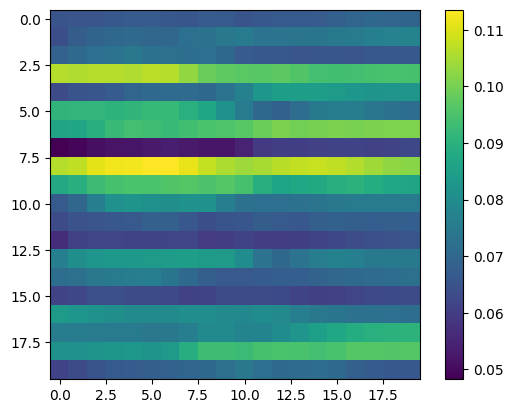

In [21]:
dCKA_mat = dCKA(n, g)
plt.imshow(dCKA_mat)
plt.colorbar()

18:58:32 - The number of datapoints used to compute extreme offsets is < than 10


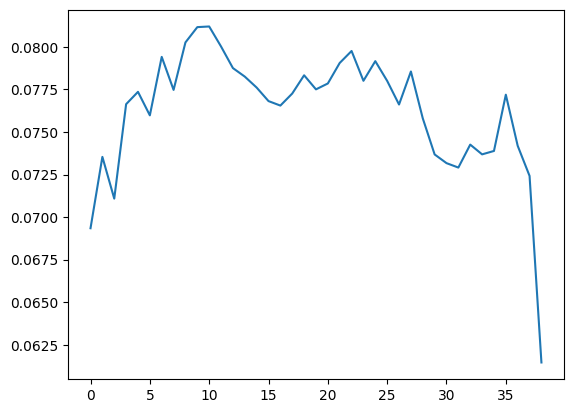

In [24]:

plt.plot(get_lagplot(dCKA_mat, max_lag=19))

19:03:29 - The number of datapoints used to compute extreme offsets is < than 10
19:03:30 - The number of datapoints used to compute extreme offsets is < than 10
19:03:30 - The number of datapoints used to compute extreme offsets is < than 10
19:03:31 - The number of datapoints used to compute extreme offsets is < than 10
19:03:31 - The number of datapoints used to compute extreme offsets is < than 10
19:03:32 - The number of datapoints used to compute extreme offsets is < than 10
19:03:32 - The number of datapoints used to compute extreme offsets is < than 10
19:03:33 - The number of datapoints used to compute extreme offsets is < than 10
19:03:34 - The number of datapoints used to compute extreme offsets is < than 10
19:03:34 - The number of datapoints used to compute extreme offsets is < than 10
19:03:35 - The number of datapoints used to compute extreme offsets is < than 10
19:03:35 - The number of datapoints used to compute extreme offsets is < than 10
19:03:36 - The number of dat

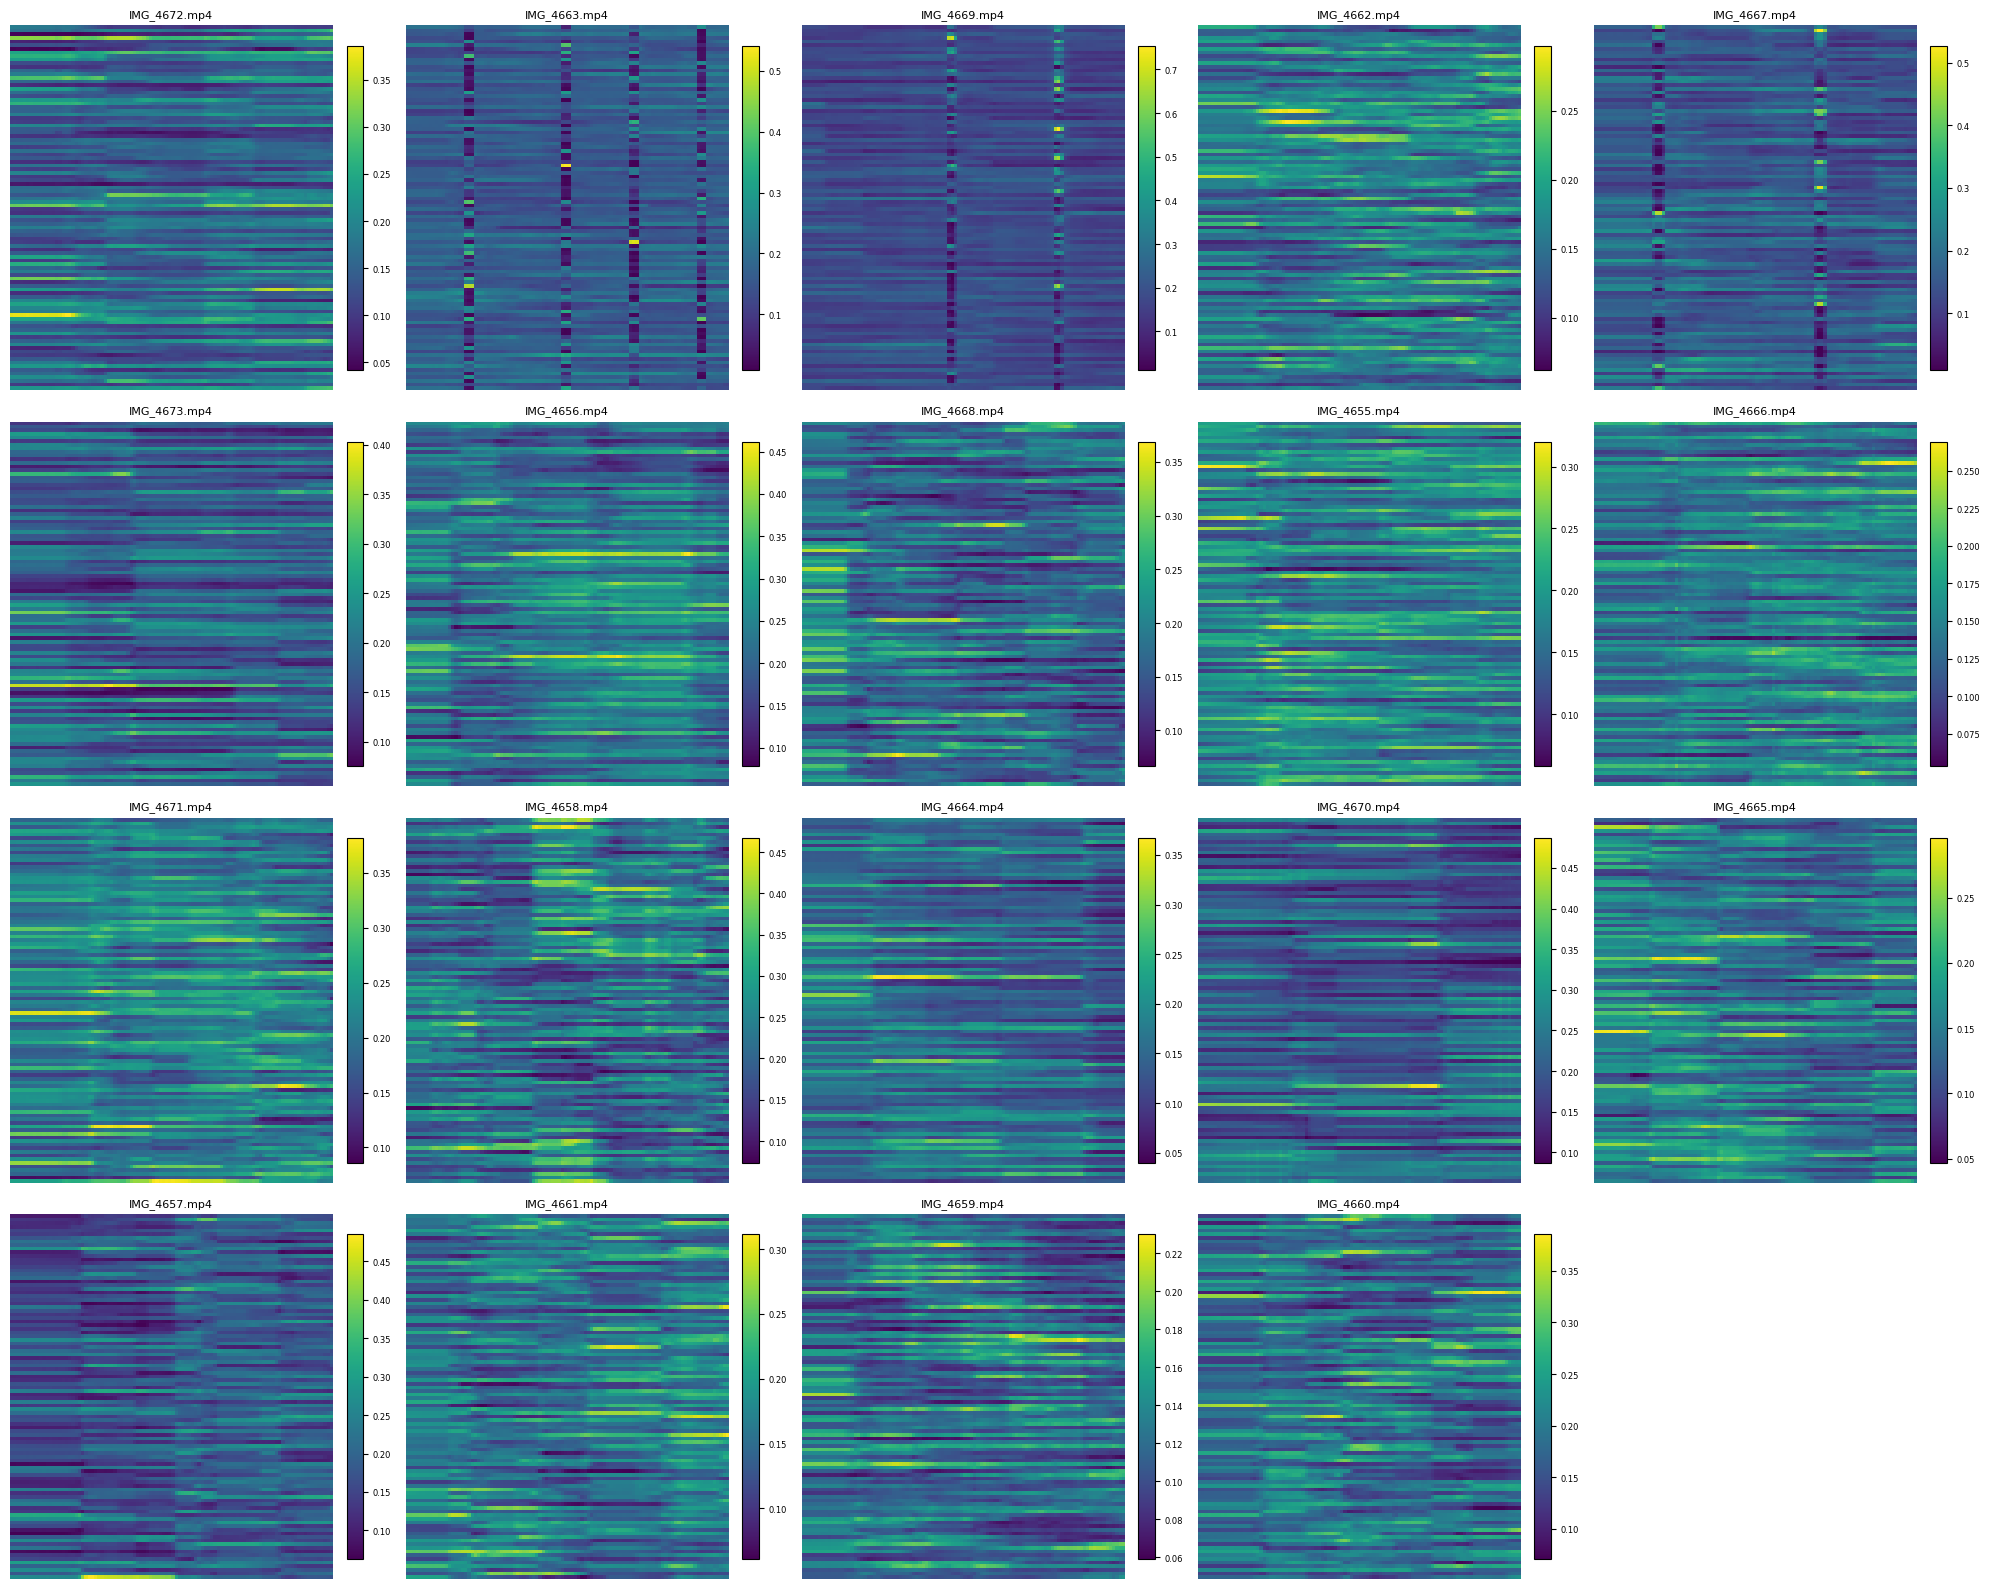

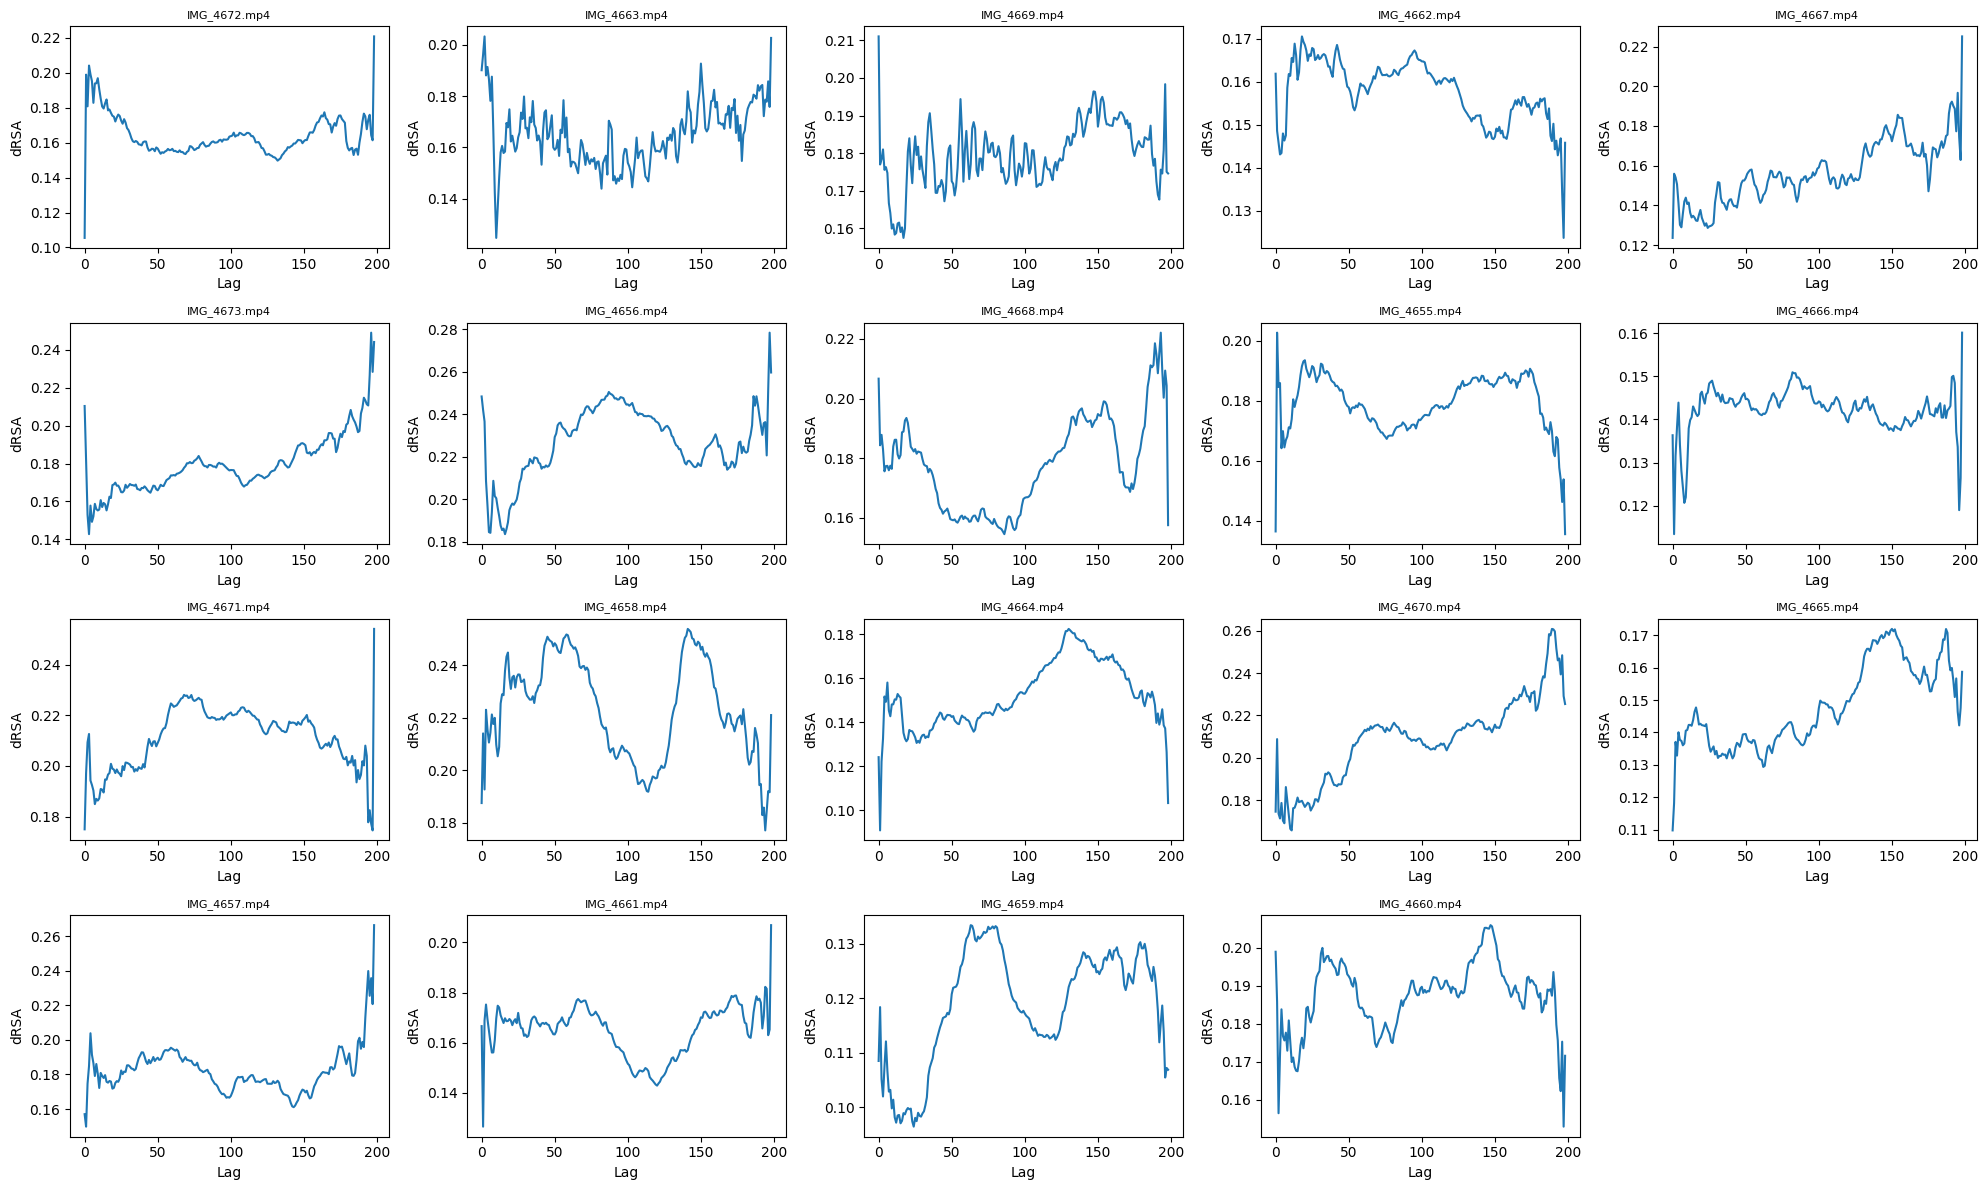

In [30]:
import matplotlib.pyplot as plt
import math

fns = list(n_norm.keys())
n_fns = len(fns)
lagplots = []

# -----------------------------
# FIGURE 1 — HEATMAPS
# -----------------------------

n_cols = math.ceil(math.sqrt(n_fns))
n_rows = math.ceil(n_fns / n_cols)

fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes1 = axes1.flatten()

for ax, fn in zip(axes1, fns):
    # compute fixation responses
    neural_data_fix, gaze_data_fix, model_data_fix = extract_fixation_responses_sing_trial(
        n_norm, gaze_data, all_models, fn, 0, 0, 100, stack=1
    )
    if neural_data_fix.shape[2] > 1:
        # compute dRSA
        dRSA = dCKA(
            neural_data_fix[:, :, :],
            gaze_data_fix[:, :, :],
        )
        lagplots.append(get_lagplot(dRSA, max_lag=99))

        # plot heatmap
        im = ax.imshow(dRSA, aspect='auto', cmap='viridis')
        ax.set_title(fn, fontsize=8)
        ax.axis('off')

        # colorbar
        cbar = fig1.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=6)
    else:
        lagplots.append(np.array([]))

# turn off unused axes
for ax in axes1[len(fns):]:
    ax.axis('off')

fig1.tight_layout()


# -----------------------------
# FIGURE 2 — LAG PLOTS
# -----------------------------

fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes2 = axes2.flatten()

for ax, fn, lag_vals in zip(axes2, fns, lagplots):
    
    ax.plot(lag_vals)
    ax.set_title(fn, fontsize=8)
    ax.set_xlabel('Lag')
    ax.set_ylabel('dRSA')

# turn off unused axes
for ax in axes2[len(lagplots):]:
    ax.axis('off')

fig2.tight_layout()

# -----------------------------
# SHOW BOTH FIGURES
# -----------------------------
plt.show()

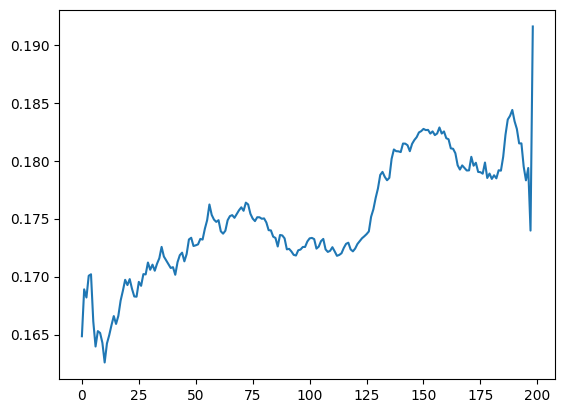

In [31]:
plt.plot(np.mean(np.stack(lagplots, axis=-1), axis=-1))